# Preprocessing Model
The main goals of this model is to classify project_description and project_school_name into its own coloumns
# Questions to ask?
Where are all these cities from new york? -> note we have ageograhpc location dummy!
If the new data has cities outisde of new york how to handle?
If the current/new data has mispelling how to handle (probabilisitc method?)

# Supervised Learning : NPL
We first create a tokeniser and then identify throuhg a school_type_dict to automate manual labelling and then implement a naive bayes algorithm for classify future projects. we find X000 - BRONX, M000 - MANHATTAN, K000 - BROOKLYN, NEW BRIDGES, Q000 - QUEENS, K000 - BROOKLYN  problamatic labels. We assume each is either a k-12 school 
Next we create a neural network for future unlablled datasets to classify project_school_name into a cateogry of {Pre-School, Primary/Hihg/Middle school, University, Admisnitrative}.


In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('/Users/shahid/Github/data-society-ibm-ml-project/data/interim/phase-two-time-cost-ratio-diff/data_removed_missing_values_null_na_illogical_date_added_time_cost_diff_and_ratio.csv')

## text-normilisation and text-tokenizing

In [12]:
import nltk
import re 
from nltk.tokenize import word_tokenize

def preprocessText(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove all punctuation except .
    pattern = r'[^\w\s.]'
    text_without_punctuation = re.sub(pattern, '', text)
    
    # Remove numbers
    text_cleaned = re.sub(r'\d+', '', text_without_punctuation)

    # Tokenize the text
    tokens = word_tokenize(text_cleaned.lower())

    return tokens

# Remove all numbers and punctiation from string 
def findTypeSchool(tokens_arr):
    
    found_school_type = False
    school_type = 'Primary/Middle/High School/Institute'
    school_type_dict = {"Pre-School": ["prek", "child", "pre", "care", "preschool", "early",],
                    "Primary/Middle/High School/Institute": ["hig", "middl", "i.s.h.s", "primary", "i.s.j.h.s", "schoo", "middlehs", "mccown", 
                                                             "ischool","p.p.a.s","sch", "middle/hs", "j.h.s", "acade", "preparatory","elem", 
                                                             "prep", "lyfe", "i.s.j.h.s.", "psis", "i.s.j.h.s.", "sped", "schl", "p.s.i.s", "elementary", 
                                                             "scndry", "academy", "j.h.s", "h.s", "h.s.", "i.s", "m.s.h.s", "m.s.h.s.", "m.s", "high", "institute", 
                                                             "middle", "middle", "high", "institue", "school", "arts" , "p.s.", "hs", "ms", "ps", "p.s"],
                    "Univeristy" : ["satellite", "drug", "adult", "collegiate", "community", "uni", "u", "college", "coll", "col", "u.", "university", "diploma"], 
                    "Board of Education/Adminsitrative/Bureau" : ["bureau", "div.", "infodata", "admin", "administrative", "office"]}
    
    for token in tokens_arr:
        for key, values in school_type_dict.items():
            if token in values:
                found_school_type = True
                school_type = key 
                break  # Break inner loop if match is found
        if found_school_type:
            break  # Break outer loop if match is found
    
    return school_type

school_type_arr = {}
count_wrong = 0

for index, value in enumerate(df['project_school_name']):
    tokens_arr = preprocessText(value)
    school_type = findTypeSchool(tokens_arr)
    school_type_arr[index] = [school_type, value]
        
#print(school_type_arr)

## Problametic automated labels
From the automated label we find #X000 - BRONX, M000 - MANHATTAN, K000 - BROOKLYN, NEW BRIDGES, Q000 - QUEENS, K000 - BROOKLYN to be Probalamtic, we assume that they are primary/high/middle school 

## Visualising Class Imbalance 

### Problametic automated labels
From the automated label we find #X000 - BRONX, M000 - MANHATTAN, K000 - BROOKLYN, NEW BRIDGES, Q000 - QUEENS, K000 - BROOKLYN to be Probalamtic, we assume that they are primary/high/middle school 

count for pre-schoool: 90, primary/high/middle : 7872, unvieristy: 183, admin:23


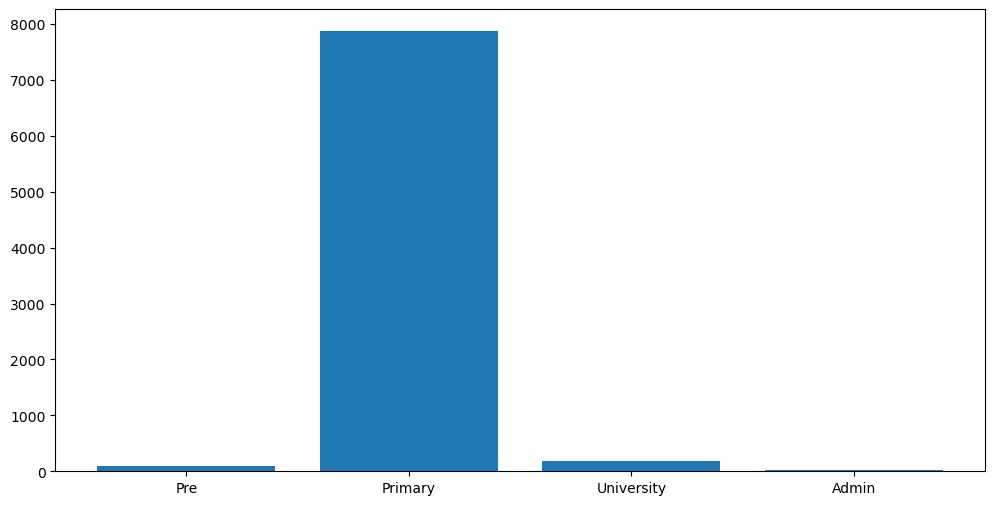

In [18]:
import matplotlib.pyplot as plt 

# count for each class in school_type_dict 
def countSchoolNumber(school_type_arr):
    primary_high_middle_count = 0 
    pre_count = 0 
    university_count = 0 
    admin_count = 0 
    for value in school_type_arr.values():
        match value[0]:
            case 'Primary/Middle/High School/Institute':
                primary_high_middle_count += 1 
            case "Pre-School":
                pre_count += 1 
            case "Univeristy":
                university_count += 1
            case "Board of Education/Adminsitrative/Bureau":
                admin_count += 1
    return pre_count, primary_high_middle_count, university_count, admin_count

# Creats a bar Chart
def barChartPlot(values_count, school_type_count_dic):
    plt.figure(figsize=(12,6))
    plt.bar(school_type_count_dic, values_count)
    plt.show()
    return


pre_count, primary_high_middle_count, university_count, admin_count = countSchoolNumber(school_type_arr)
print(f"count for pre-schoool: {pre_count}, primary/high/middle : {primary_high_middle_count}, unvieristy: {university_count}, admin:{admin_count}")
values_count = [pre_count, primary_high_middle_count, university_count, admin_count]
keys = ['Pre', 'Primary', 'University', 'Admin']

# plt 
plt.figure(figsize=(12,6))
plt.bar(keys,values_count)
plt.show()

## Why chose naive bayes?
Importantly naive bayes assume indepedence between each word, alike to our automated labelling function my hope is that the weights words included in the school_type_dict are heavily weighted enabling generlisation whilst also offering precision and accuracy
### Naive Bayes

From bayes rule we find, 
$$
\begin{align*}
  P(class | text) &= \frac{P(text | class)P(class)}{P(text)}  
\end{align*}
$$
Use MLE to find the probaiblity of Class 

$$
\begin{align*}
    c_{MLE} & = argmax P(class | text) \\ 
    &= argmax \frac{P(text | class)P(class)}{P(text)}  \\
    &= argmax P(text | class)P(class) \\ 
    &= argmax P(x1,x2,x3,x3,......|class)P(class) \quad\quad\text{Text = [word1,word2, word3...] }\\ 
    &= argmax P(class)\prod_{i = 1}^n P(x_i | class) \\  
    &= argmax log(P(class)) + \sum_{i = 1}^n log(P(x_i | class) \quad\quad(\text{Naive Bayes assumption of independence})
\end{align*}
$$

Using this we a estimate,

$$
\begin{align*}
\hat{P}(class) &= \frac{\text{Number of times a text = class}}{\text{Number of documents}} \\ 
\hat{P}(word_i | class_i) &= \frac{\text{count(word_i, c_j) +} \alpha}{\sum (count(words, class_i) + \alpha)} = \frac{\text{Fract of times w_i appears in class_j + Laplace Smoothing}}{\text{number of words in class_j + Laplace Smoothing}}
\end{align*}
$$

In [19]:
# Randomly split data into training 
from sklearn.utils import shuffle

def randomShuffleTraingTest(df, percentage_training):
    length_training_set = int(len(df)) * percentage_training

    # shuffle exsiting dataframe
    np.random.seed(1) 
    random_shuffle_df = shuffle(df)
    # Creating new test/train set 
    
    train_set = random_shuffle_df.iloc[:int(length_training_set)]
    train_set['index'] = np.arange(0, len(train_set))
    train_set.set_index('index')
    test_set = random_shuffle_df.iloc[int(length_training_set):]
    test_set['index'] = np.arange(0, len(test_set))
    test_set.set_index('index')
    return train_set, test_set

# Creating new df with new project_school_type # initliased as column zero
train_set, test_set = randomShuffleTraingTest(df, 0.8)
print(len(train_set))
print(len(test_set))

# Find number of classes in test and training set
# Counts Number of Classess in traing data
train_set['project_school_type'].unique()
train_set.head()

# Split train set into train and validation set
validation_set_size = int(len(train_set) * 0.1)
validation_set = train_set.iloc[0:validation_set_size]
train_set = train_set.iloc[validation_set_size:len(train_set)]

type_counts = train_set['project_school_type'].value_counts()

print(len(train_set))
print(len(validation_set))
print(type_counts)

6534
1634


/var/folders/0m/tjm8n82117bg4plwvf105j2h0000gn/T/ipykernel_90545/1978581818.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['index'] = np.arange(0, len(train_set))
/var/folders/0m/tjm8n82117bg4plwvf105j2h0000gn/T/ipykernel_90545/1978581818.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['index'] = np.arange(0, len(test_set))


KeyError: 'project_school_type'

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_score

# Posterior Distribution Using Test
num_samples = len(train_set)
prob_admin_class =  16 / num_samples
prob_pre_school = 61 / num_samples
prob_primary_high = 5684 / num_samples
prob_uni = 120 / num_samples

posterior_distribution_class_probability = {
    "Board of Education/Adminsitrative/Bureau": prob_admin_class,
    "Pre-School": prob_pre_school,
    "Primary/Middle/High School/Institute": prob_primary_high,
    "Univeristy": prob_uni
}

# Making our vocab from train_set
vocab_word_count = {
    "Pre-School": {},
    "Primary/Middle/High School/Institute": {},
    "Univeristy": {},
    "Board of Education/Adminsitrative/Bureau": {}
}
total_number_of_words = {
    "Pre-School": 0,
    "Primary/Middle/High School/Institute": 0,
    "Univeristy": 0,
    "Board of Education/Adminsitrative/Bureau": 0
}

for index, row in train_set.iterrows():
    # Initialize project school name array and type
    tokens_arr = preprocessText(row['project_school_name'])
    class_value = row['project_school_type']

    # Loop over characters and create a vocab of words
    for token in tokens_arr:
        if token not in vocab_word_count[class_value]:
            vocab_word_count[class_value][token] = 1
        else:
            vocab_word_count[class_value][token] += 1

    # Add number of words to total word count of class
    total_number_of_words[class_value] += len(tokens_arr)

# Loop over test data, Tokenize each test sample, then find maximum likelihood estimator for each estimate

arr_predict = []
laplace_smooth = 0.001
while laplace_smooth < 0.01:
    arr_predict.clear()
    for index, row in validation_set.iterrows():
        # Convert to tokens
        tokens_arr = preprocessText(row['project_school_name'])
        
        # Count holder
        arg_sum_dict = {key: 0 for key in vocab_word_count.keys()}
        
        # Go through each class of project_school_type
        for key in vocab_word_count.keys():
            # Compute log(posterior(class))
            log_class_prob = np.log(posterior_distribution_class_probability[key])
            sum_class = log_class_prob
            
            for token in tokens_arr:
                # Find probability of token in this class
                number_of_time_token_in_vocab = vocab_word_count[key].get(token, 0) + laplace_smooth
                probaiblity_of_token = number_of_time_token_in_vocab / (total_number_of_words[key] + laplace_smooth * len(vocab_word_count[key]))
                sum_class += np.log(probaiblity_of_token)
                
            # Add sum to dictionary
            arg_sum_dict[key] = sum_class
    
        # Find the max probability
        max_value_label = max(arg_sum_dict, key=arg_sum_dict.get)
    
        arr_predict.append(max_value_label)

    print(classification_report(arr_predict, validation_set['project_school_type']))
    laplace_smooth += 0.001



From a telescoping Sum we find the best hypeer paramter for laplace_smoothing = 0.001 for each word in the naive bayes algorithm. Note we did not use K-fold Validation!


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, precision_score

# Posterior Distribution Using Test
num_samples = len(train_set)
prob_admin_class =  16 / num_samples
prob_pre_school = 61 / num_samples
prob_primary_high = 5684 / num_samples
prob_uni = 120 / num_samples

posterior_distribution_class_probability = {
    "Board of Education/Adminsitrative/Bureau": prob_admin_class,
    "Pre-School": prob_pre_school,
    "Primary/Middle/High School/Institute": prob_primary_high,
    "Univeristy": prob_uni
}

# Making our vocab from train_set
vocab_word_count = {
    "Pre-School": {},
    "Primary/Middle/High School/Institute": {},
    "Univeristy": {},
    "Board of Education/Adminsitrative/Bureau": {}
}
total_number_of_words = {
    "Pre-School": 0,
    "Primary/Middle/High School/Institute": 0,
    "Univeristy": 0,
    "Board of Education/Adminsitrative/Bureau": 0
}

for index, row in train_set.iterrows():
    # Initialize project school name array and type
    tokens_arr = preprocessText(row['project_school_name'])
    class_value = row['project_school_type']

    # Loop over characters and create a vocab of words
    for token in tokens_arr:
        if token not in vocab_word_count[class_value]:
            vocab_word_count[class_value][token] = 1
        else:
            vocab_word_count[class_value][token] += 1

    # Add number of words to total word count of class
    total_number_of_words[class_value] += len(tokens_arr)

# Loop over test data, Tokenize each test sample, then find maximum likelihood estimator for each estimate

arr_predict = []
laplace_smooth = 0.001
arr_predict.clear()
for index, row in test_set.iterrows():
    # Convert to tokens
    tokens_arr = preprocessText(row['project_school_name'])
    
    # Count holder
    arg_sum_dict = {key: 0 for key in vocab_word_count.keys()}
    
    # Go through each class of project_school_type
    for key in vocab_word_count.keys():
        # Compute log(posterior(class))
        log_class_prob = np.log(posterior_distribution_class_probability[key])
        sum_class = log_class_prob
        
        for token in tokens_arr:
            # Find probability of token in this class
            number_of_time_token_in_vocab = vocab_word_count[key].get(token, 0) + laplace_smooth
            probaiblity_of_token = number_of_time_token_in_vocab / (total_number_of_words[key] + laplace_smooth * len(vocab_word_count[key]))
            sum_class += np.log(probaiblity_of_token)
            
        # Add sum to dictionary
        arg_sum_dict[key] = sum_class

    # Find the max probability
    max_value_label = max(arg_sum_dict, key=arg_sum_dict.get)

    arr_predict.append(max_value_label)

print(classification_report(arr_predict, test_set['project_school_type']))



In [ ]:
# Checking Correlation :(
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
df_practice = df.copy()

le = LabelEncoder()
le.fit(["Primary/Middle/High School/Institute", "Pre-School", "Univeristy", "Board of Education/Adminsitrative/Bureau"])
poo = list(le.transform(df_practice['project_school_type']))

hot = OneHotEncoder()
# Reshape 'failure' column to be a 2D array-like
failure_reshaped = df_practice['failure'].values.reshape(-1, 1)

# Fit and transform using OneHotEncoder
one_hot_encoded = hot.fit_transform(failure_reshaped)

# Convert sparse matrix to DataFrame for visualization (optional)
one_hot_df = pd.DataFrame(one_hot_encoded.toarray(), columns=hot.categories_[0])

np.corrcoef(poo, one_hot_df[True])

In [4]:
df

,Unnamed: 0,project_geographic_district,project_school_name,project_type,project_description,project_phase_name,project_status_name,project_phase_actual_start_date,project_phase_planned_end_date,project_phase_actual_end_date,...,time_diff_planned_end_date_minus_actual_start_date,time_diff_actual_end_date_minus_planned_end_date,schedule_performance_ratio,schedule_variance_ratio,cost_diff_project_budget_amount_minus_final_estimate_of_actual_costs_through_end_of_phase_amount,cost_diff_project_budget_amount_minus_total_phase_actual_spending_amount,cost_diff_final_estimate_of_actual_costs_through_end_of_phase_amount_minus_total_phase_actual_spending_amount,cost_performance_index,budget_efficiency_ratio,cost_variance
0,0,10,I.S. 254 - BRONX,SCA CIP,FACADE/ROOFS,Construction,In-Progress,07/07/2016,03/28/2018,NaN,...,629,Nan,Nan,Nan,-179193,258873,438066,1.1155503363511694,1.0682839166295406,0.10816444444444444
1,1,10,I.S. 254 - BRONX,SCA CIP,FACADE/ROOFS,"CM, F&E",In-Progress,07/07/2016,03/28/2018,NaN,...,629,Nan,Nan,Nan,-237326,-233620,3706,1.0076314814052139,0.518924261768461,0.014706349206349206
2,2,10,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Scope,Complete,07/27/2017,11/27/2017,08/03/2017,...,123,-116,0.056910569105691054,-0.943089430894309,-1792,-1792,0,1.0,0.0,Not recorded yet
3,3,10,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Design,In-Progress,08/04/2017,02/05/2018,NaN,...,185,Nan,Nan,Nan,1792,11941,10149,2.415678616264472,2.665643743897336,0.531083202511774
4,4,10,I.S. 254 - BRONX,SCA CIP RESOA,FY16 RESO A IP SURVEILLANCE CAMERA INSTALLATION,Construction,PNS,PNS,PNS,PNS,...,Nan,Nan,Nan,Nan,0,279329,279329,294.72134595162987,294.72134595162987,0.9966069644641073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8163,8180,32,P.S. 45 - BROOKLYN,DOE - Skilled Trades,REPLACE (8) UNIVENTS,Construction,In-Progress,02/09/2017,DOES,NaN,...,Nan,Nan,Nan,Nan,0,507628,106270,1.8692273716239427,Nan,Nan
8164,8181,32,BUSHWICK LEADERS - K,SCA CIP,CERTIFICATE OF OCCUPANCY,Scope,Complete,06/18/2013,12/02/2013,11/18/2013,...,167,-14,0.9161676646706587,-0.08383233532934131,-31451,-25475,5976,1.05032463431271,0.7854718776579172,0.06406930119861912
8165,8182,32,BUSHWICK LEADERS - K,SCA CIP,CERTIFICATE OF OCCUPANCY,Design,In-Progress,11/19/2013,05/22/2014,NaN,...,184,Nan,Nan,Nan,-122352,34494,156846,1.4632164015569902,1.101871814106237,0.42039046250830886
8166,8183,32,BUSHWICK LEADERS - K,SCA CIP,CERTIFICATE OF OCCUPANCY,Construction,PNS,PNS,PNS,PNS,...,Nan,Nan,Nan,Nan,0,6888344,6888344,65.2545427409425,65.2545427409425,0.9846753964092592
